In [1]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform
import os
import requests
import shutil
import random
from PIL import Image

device = "cuda" if torch.cuda.is_available() else 'cpu'

## Download Dataset

In [8]:
!pip install kaggle

In [9]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
!cp kaggle.json ~/.kaggle/

In [11]:
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!pip install opendatasets

In [13]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/jangedoo/utkface-new")


100%|██████████| 331M/331M [00:13<00:00, 25.9MB/s]


# Preparation Dataset

In [14]:
past_folder = '/content/utkface-new/UTKFace'
new_folder = '/content/dataset'

train_ann_path = '/content/train_ann.txt'
test_ann_path = '/content/test_ann.txt'

if not os.path.exists(new_folder):
    os.mkdir(new_folder)

train_folder = os.path.join(new_folder, 'train')
test_folder = os.path.join(new_folder, 'test')
if not os.path.exists(train_folder):
    os.mkdir(train_folder)
if not os.path.exists(test_folder):
    os.mkdir(test_folder)

train_cnt = 0
test_cnt = 0
with open(train_ann_path, 'w') as train_ann, open(test_ann_path, 'w') as test_ann:
    for filename in os.listdir(past_folder):
        file_path = os.path.join(past_folder, filename)
        mask = random.choices([0, 1], weights=[0.1, 0.9], k=1)[0]
        prefix = filename.split('_')
        if len(prefix) != 4:
            continue
        if mask:
            train_cnt += 1
            filename = str(train_cnt) + '.jpg'
            destination_path = os.path.join(train_folder, filename)
            shutil.copy(file_path, destination_path)

            train_ann.write('|'.join(prefix) + '\n')
        else:
            test_cnt += 1
            filename = str(test_cnt) + '.jpg'
            destination_path = os.path.join(test_folder, filename)
            shutil.copy(file_path, destination_path)

            test_ann.write('|'.join(prefix) + '\n')


# Create Dataset

In [15]:
class UTKface(Dataset):
    def __init__(self, images_path, ann_path, phase, transform=None):
        self.images_path = images_path
        self.ann_path = ann_path
        self.transform = transform
        self.phase = phase

    def __getitem__(self, idx):
        idx += 1
        image_path = os.path.join(self.images_path, str(idx) + ".jpg")
        image = Image.open(image_path).convert('RGB')
        if self.transform != None:
            image = self.transform(image)

        with open(self.ann_path, 'r') as file:
            lines = file.readlines()
            label = int(lines[idx - 1].split("|")[self.phase])
        data = {"image":image, "label":label}
        return data
    def __len__(self):
        return len(os.listdir(self.images_path))


In [16]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.2),
    # transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5957, 0.4559, 0.3901), (0.2184, 0.1944, 0.1852))
])
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5957, 0.4559, 0.3901), (0.2184, 0.1944, 0.1852))
])

In [17]:
TrainSet_age = UTKface("/content/dataset/train", "/content/train_ann.txt", 0, train_transform)
TrainSet_gender = UTKface("/content/dataset/train", "/content/train_ann.txt", 1, train_transform)
TrainSet_race = UTKface("/content/dataset/train", "/content/train_ann.txt", 2, train_transform)
TestSet_age = UTKface("/content/dataset/test", "/content/test_ann.txt", 0, test_transform)
TestSet_gender = UTKface("/content/dataset/test", "/content/test_ann.txt", 1, test_transform)
TestSet_race = UTKface("/content/dataset/test", "/content/test_ann.txt", 2, test_transform)

In [18]:
TrainLoader_age = torch.utils.data.DataLoader(TrainSet_age,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_age = torch.utils.data.DataLoader(TestSet_age,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

TrainLoader_gender = torch.utils.data.DataLoader(TrainSet_gender,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_gender = torch.utils.data.DataLoader(TestSet_gender,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

TrainLoader_race = torch.utils.data.DataLoader(TrainSet_race,
                                             batch_size=1, shuffle=True,
                                             num_workers=2)
TestLoader_race = torch.utils.data.DataLoader(TestSet_race,
                                             batch_size=1, shuffle=False,
                                             num_workers=2)

In [19]:
next(iter(TrainLoader_age))

{'image': tensor([[[[-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           ...,
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276],
           [-2.7276, -2.7276, -2.7276,  ..., -2.7276, -2.7276, -2.7276]],
 
          [[-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           ...,
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452],
           [-2.3452, -2.3452, -2.3452,  ..., -2.3452, -2.3452, -2.3452]],
 
          [[-2.1064, -2.1064, -2.1064,  ..., -2.1064, -2.1064, -2.1064],
    

# Plot Images

In [ ]:
def plot_batch(batch):
    images = batch["image"]
    labels = batch["label"]
    race = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}

    batch_size = images.size(0)
    grid_size = int(np.ceil(np.sqrt(batch_size)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i in range(batch_size):
        image = images[i].permute(1, 2, 0).numpy()
        label = labels[i].item()

        ax = axs[i // grid_size, i % grid_size]
        ax.imshow(image)
        ax.set_title(f"race: {race[label]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


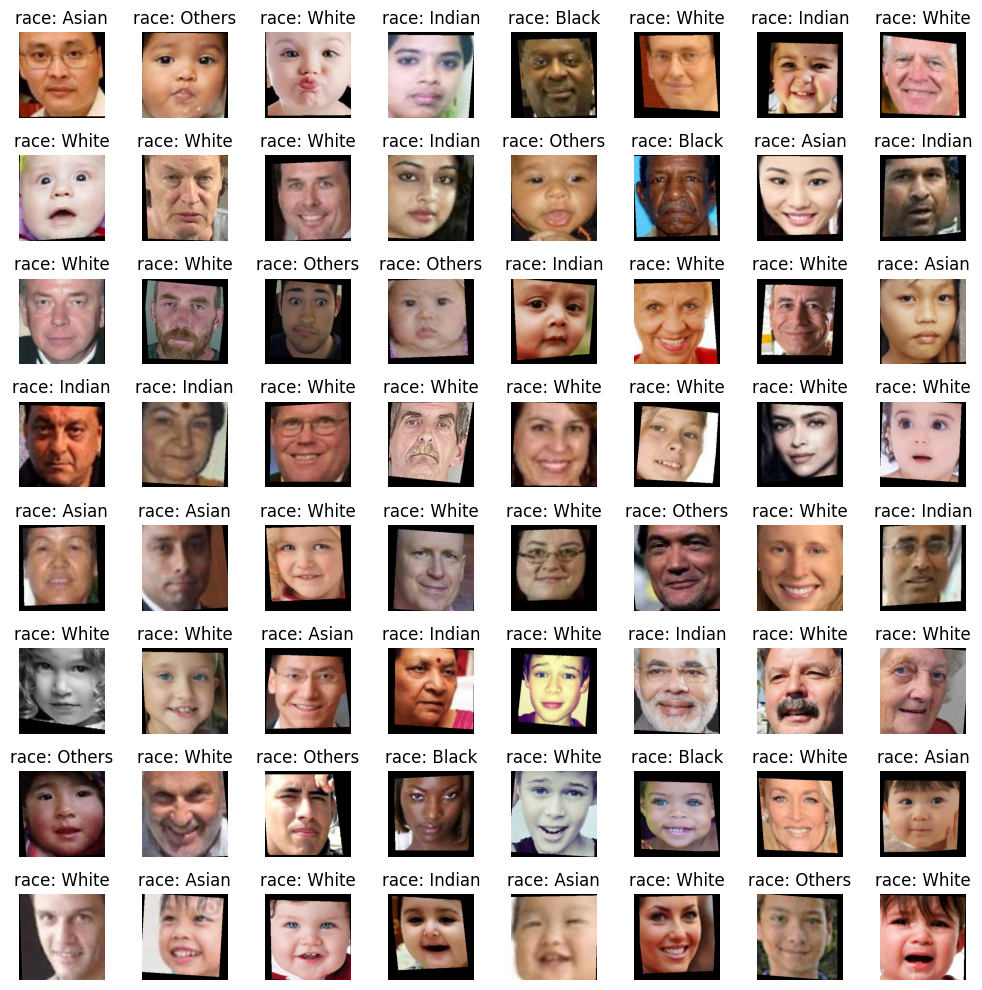

In [ ]:
batch = next(iter(TrainLoader_race))
plot_batch(batch)

# Create Model

In [20]:
from torch.nn.modules.linear import Linear
model = torchvision.models.efficientnet_b5(True)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4, inplace=True),
    torch.nn.Linear(in_features=2048, out_features=12, bias=True))
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth
100%|██████████| 117M/117M [00:01<00:00, 97.2MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [21]:
model = model.to(device)

# Loss Function and Optimizer

In [22]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train/Test Function

In [23]:
def Train(epoch, dataloader):
    running_loss = 0.0
    iter_loss = 0.0
    correct_predictions = 0

    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"], data["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # calculate accuracy
        correct_predictions += (predicted_labels == labels).sum().item()

        # backward + optimize
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        iter_loss += loss.item()

        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'{i + 1:5d} ===> loss: {iter_loss / 500}')
            iter_loss = 0.0

    accuracy = correct_predictions / len(dataloader.dataset)
    print(f'Train loss ---------> {running_loss / i}')
    print(f'Train accuracy -----> {accuracy}')
    running_loss = 0.0

In [24]:
def Test(dataloader):
    running_loss = 0.0
    correct_predictions = 0

    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"], data["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)

        # calculate accuracy
        correct_predictions += (predicted_labels == labels).sum().item()

        #loss
        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()

    accuracy = correct_predictions / len(dataloader.dataset)
    print(f'Test loss ---------> {running_loss / i}')
    print(f'Test accuracy -----> {accuracy}')
    running_loss = 0.0

# Train

In [25]:
epochs = 10
train_loader = TrainLoader_race
test_loader = TestLoader_race

In [ ]:
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}:')
    Train(epoch, train_loader)
    Test(test_loader)
    torch.save(model, f'/content/saves/race_estimation{epoch + 1}.pth')
print('Finished Training')

Epoch 1:
  500 ===> loss: 1.5516495664715766
 1000 ===> loss: 1.4906208143234252
 1500 ===> loss: 1.3788088153600693
 2000 ===> loss: 1.2611675359904766
 2500 ===> loss: 1.1219719903469085
 3000 ===> loss: 1.1425457022637129
 3500 ===> loss: 1.0067593797221779
 4000 ===> loss: 1.057447741754353
 4500 ===> loss: 0.9350247631706298
 5000 ===> loss: 0.9270706497430802
 5500 ===> loss: 0.8522498020008207
 6000 ===> loss: 0.8103295522667467
 6500 ===> loss: 0.8074322224631906
 7000 ===> loss: 0.8087481305077672
 7500 ===> loss: 0.740913074972108
 8000 ===> loss: 0.6953566163107753
 8500 ===> loss: 0.7440601287446916
 9000 ===> loss: 0.749243383359164
 9500 ===> loss: 0.7438273405693472
10000 ===> loss: 0.6952903621476143
10500 ===> loss: 0.7558606643751263
11000 ===> loss: 0.7769406807962805
11500 ===> loss: 0.701224805906415
12000 ===> loss: 0.7363707022331655
12500 ===> loss: 0.6884229713287204
13000 ===> loss: 0.6150154200475663
13500 ===> loss: 0.6481254053693265
14000 ===> loss: 0.6488

# Check Answers

In [ ]:
false_estimates = []
for i in range(1965):
  if i % 500 == 0:
    print(i)
  data = TestSet_race[i]
  input, label = data["image"], data["label"]
  input = input.unsqueeze(dim=0)
  model.to('cpu')
  out = model(input)
  _, predicted_labels = torch.max(out, 1)
  if predicted_labels.item() != label:
    false_estimates.append((input, label, predicted_labels.item()))
print(len(false_estimates))

357


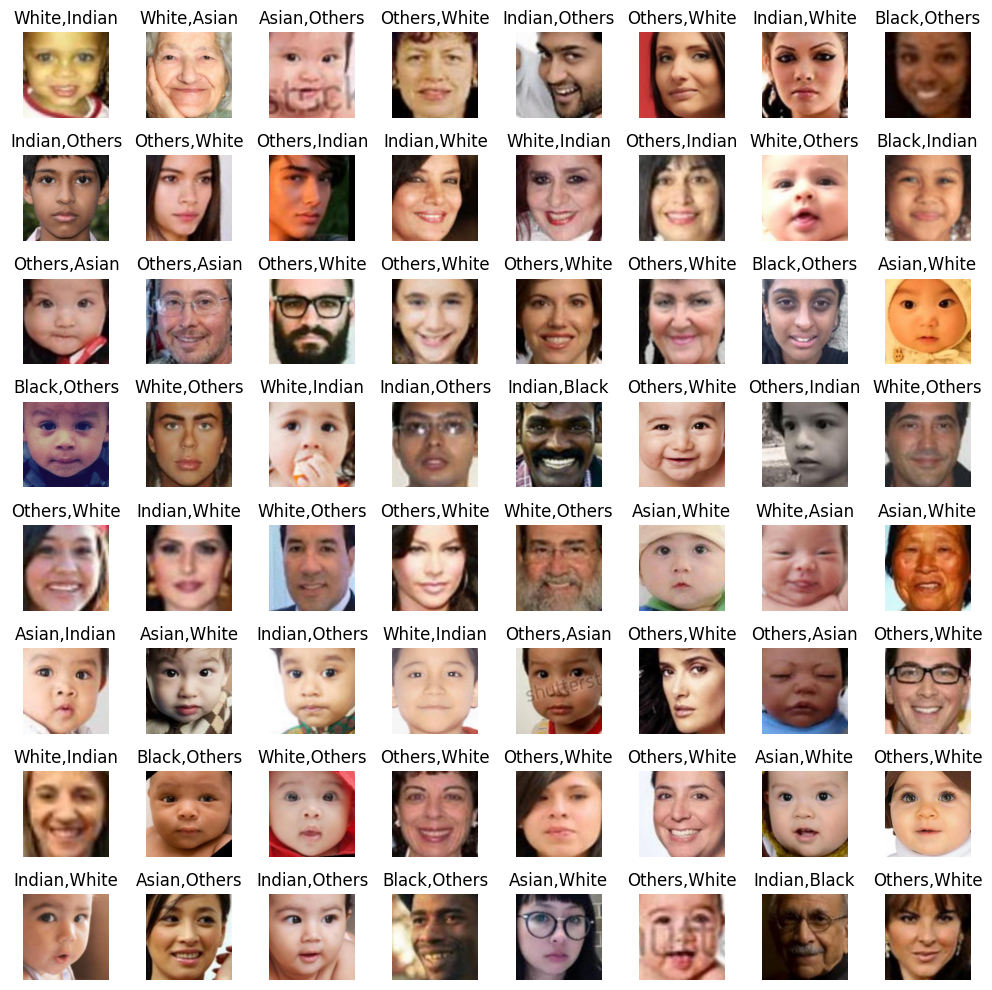

In [ ]:
batch_size = 64

grid_size = int(np.ceil(np.sqrt(batch_size)))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

print(len(false_estimates))
race = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}

for i in range(batch_size):
    image = false_estimates[i][0][0].permute(1, 2, 0).numpy()
    label = false_estimates[i][1]
    out_label = false_estimates[i][2]

    ax = axs[i // grid_size, i % grid_size]
    ax.imshow(image)
    ax.set_title(f"{race[label]},{race[out_label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# More Information

check
4h 27m

10 Epochs

Train loss ---------> 0.4394109109111958

Train accuracy -----> 0.853576594652606

Test loss ---------> 0.48363275200008093

Test accuracy -----> 0.8412489006156553